<a href="https://colab.research.google.com/github/nandinib1999/credit-card-fraud-detection/blob/main/Credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://drive.google.com/file/d/152cDq2FOaR5SLUdn_z8dLTcwNAYtetZT/view?usp=sharing
import gdown

url = 'https://drive.google.com/uc?id=152cDq2FOaR5SLUdn_z8dLTcwNAYtetZT'
output = 'creditcard.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=152cDq2FOaR5SLUdn_z8dLTcwNAYtetZT
To: /content/creditcard.csv
151MB [00:02, 74.4MB/s]


'creditcard.csv'

In [2]:
!ls

creditcard.csv	sample_data


In [3]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

In [4]:
df = pd.read_csv("creditcard.csv")


In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Number of fraud cases 

In [7]:
fraud_df = df[df['Class']==1]
normal_df = df[df['Class']==0]
len(fraud_df),len(normal_df)

(492, 284315)

In [8]:
non_fraud = df[df['Class'] == 0].sample(2000)
fraud = df[df['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
x = df.drop(['Class'], axis = 1).values
y = df["Class"].values

## Visualising the data

In [9]:
x,y

(array([[ 1.23525000e+05, -5.90492081e+00,  4.43991138e+00, ...,
         -1.16756581e+00, -1.20635433e+00,  4.55100000e+01],
        [ 9.15020000e+04,  7.37907511e-03,  2.36518253e+00, ...,
         -4.47529183e-01, -3.62374775e-01,  1.00000000e+00],
        [ 3.77760000e+04, -1.53046411e+00, -7.69125241e-01, ...,
         -4.64976435e-02, -1.27855305e-01,  6.40000000e+01],
        ...,
        [ 3.46870000e+04, -4.31548376e+00,  3.10435403e+00, ...,
         -6.44524070e-01, -2.06554626e-01,  7.70000000e-01],
        [ 1.31787000e+05, -5.08014095e-01,  3.18489467e-01, ...,
         -1.82930819e-01, -9.39839855e-02,  2.37500000e+01],
        [ 7.74030000e+04,  1.21877217e+00, -3.82193274e-01, ...,
         -9.66684015e-03,  2.31312792e-02,  7.49900000e+01]]),
 array([1, 1, 0, ..., 0, 0, 0]))

In [10]:
p = TSNE(n_components=2, random_state=24).fit_transform(x)
p

array([[-12.828636 ,  68.046455 ],
       [-11.502096 , -24.81648  ],
       [  2.9259315, -19.306602 ],
       ...,
       [ 13.699748 , -25.001783 ],
       [-31.934368 ,  46.1503   ],
       [-33.705746 , -38.30237  ]], dtype=float32)

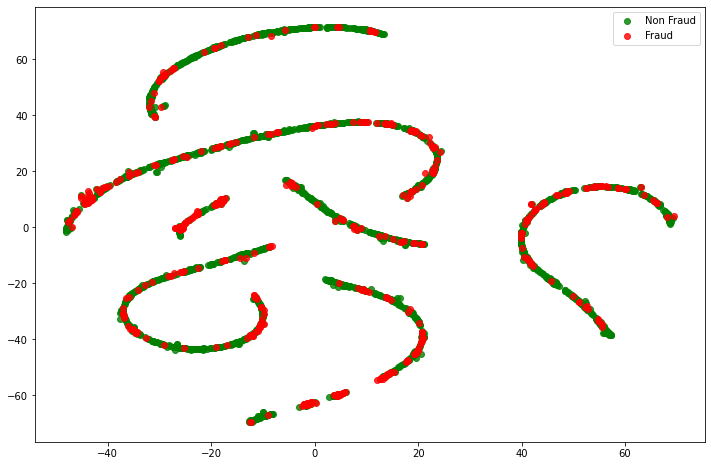

In [11]:
plt.figure(figsize=(12, 8))
plt.scatter(p[np.where(y == 0), 0], p[np.where(y == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
plt.scatter(p[np.where(y == 1), 0], p[np.where(y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

plt.legend(loc='best');
plt.show();

### Constructing the autoencoder

In [12]:
autoencoder = Sequential()

In [13]:
autoencoder.add(Dense(x.shape[1], activation='tanh'))
autoencoder.add(Dense(100, activation='tanh'))
autoencoder.add(Dense(50, activation='relu'))
autoencoder.add(Dense(50, activation='tanh'))
autoencoder.add(Dense(100, activation='tanh'))
autoencoder.add(Dense(x.shape[1], activation='relu'))

In [14]:
autoencoder.compile(optimizer="adadelta", loss="mse")

### Data Scaling

In [15]:
x_scale = preprocessing.MinMaxScaler().fit_transform(x)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

### Training the autoencoder

In [16]:
autoencoder.fit(x_norm, x_norm, 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 [==============================] - 2s 59ms/step - loss: 0.2991 - val_loss: 0.2982
Epoch 2/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2986 - val_loss: 0.2977
Epoch 3/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2981 - val_loss: 0.2972
Epoch 4/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2977 - val_loss: 0.2967
Epoch 5/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2972 - val_loss: 0.2962
Epoch 6/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2968 - val_loss: 0.2957
Epoch 7/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2963 - val_loss: 0.2952
Epoch 8/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2955 - val_loss: 0.2947
Epoch 9/10
7/7 [==============================] - 0s 22ms/step - loss: 0.2952 - val_loss: 0.2942
Epoch 10/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2946 - val_loss: 0.2937


In [17]:
autoencoder.layers

### Latent Representations

In [18]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [19]:
norm_hid_rep = hidden_representation.predict(x_norm)
fraud_hid_rep = hidden_representation.predict(x_fraud)

In [20]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

### Visualising the encoded distributions

In [21]:
p = TSNE(n_components=2, random_state=24).fit_transform(rep_x)

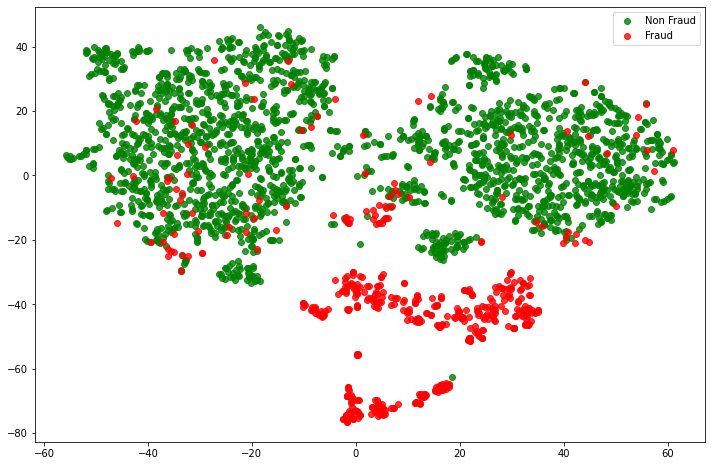

In [22]:
plt.figure(figsize=(12, 8))
plt.scatter(p[np.where(rep_y == 0), 0], p[np.where(rep_y == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
plt.scatter(p[np.where(rep_y == 1), 0], p[np.where(rep_y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

plt.legend(loc='best');
plt.show();

we can observe that now fraud and non-fraud transactions are pretty visibile and are linearly separable. Even the simpler models can be used to predict the target variable now

### Linear Classifier

In [23]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       501
         1.0       0.99      0.70      0.82       122

    accuracy                           0.94       623
   macro avg       0.96      0.85      0.89       623
weighted avg       0.94      0.94      0.94       623


Accuracy Score:  0.9406099518459069


In [24]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# define random states
state = 1

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(x),
                                        contamination=len(fraud)/float(len(x)),
                                        random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=len(fraud)/float(len(x)))}

In [25]:
n_outliers = len(fraud)


for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(x)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(x)
        scores_pred = clf.decision_function(x)
        y_pred = clf.predict(x)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != val_y)
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(y, y_pred))
    print(classification_report(y, y_pred))


Isolation Forest: True
0.9020866773675762
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2000
           1       0.75      0.75      0.75       492

    accuracy                           0.90      2492
   macro avg       0.85      0.85      0.85      2492
weighted avg       0.90      0.90      0.90      2492

Local Outlier Factor: True
0.6974317817014446
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2000
           1       0.23      0.23      0.23       492

    accuracy                           0.70      2492
   macro avg       0.52      0.52      0.52      2492
weighted avg       0.70      0.70      0.70      2492



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
